In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
import cv2
import torchvision.transforms as T
from torchinfo import summary
from torch.optim import Adam
import torchvision.ops as ops

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_train_dir, labels_val_dir, artifacts_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, filter_valid_bboxes, calculate_iou, match_anchors_to_gt
from utils import draw_image_with_box, visualize_anchors_and_gt

In [3]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_train_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['998faa48943fce6f.jpg',
 'a228f997057aa291.jpg',
 '49fe432784afea63.jpg',
 '0106e273d2de08be.jpg']

In [4]:
train_images, val_images= train_test_split(all_images, test_size= 0.2, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, max_boxes= 10, transform= transforms)
train_dataset[1]['image'].shape

torch.Size([3, 224, 224])

In [5]:
sample_image= train_dataset[2]['image']
sample_label= train_dataset[2]['boxes']

In [6]:
resnet= models.resnet50(pretrained= True)
resnet_backbone= nn.Sequential(*list(resnet.children())[:-4])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, transform= transforms)
sample_image= train_dataset[3]['image']
sample_label= train_dataset[3]['boxes']

In [8]:
all_anchors= generate_anchor_boxes(
    feature_map_shape= config.FEATURE_MAP_SHAPE,
    anchor_scales= config.ANCHOR_SCALES_2,
    anchor_ratios= config.ANCHOR_RATIOS_2,
    stride= config.ANCHOR_STRIDE,
    num_anchors_per_location= config.NUM_ANCHORS_PER_LOC
)

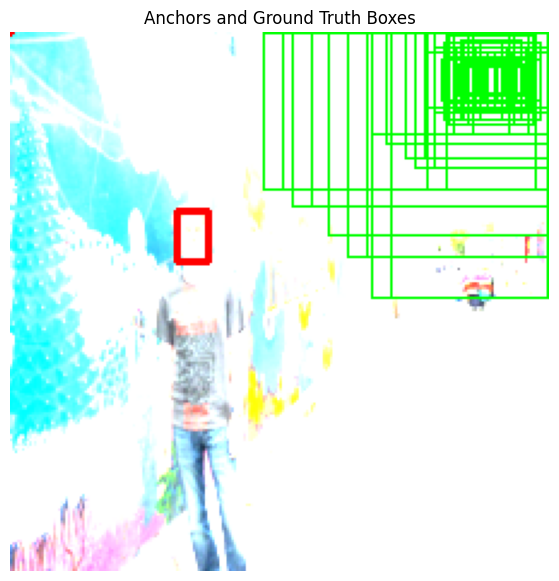

In [9]:
visualize_anchors_and_gt(sample_image, all_anchors[2000:2050], sample_label)

In [10]:
def project_bboxes(bboxes, stride, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size= bboxes.size(dim= 0)
    proj_bboxes= bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask= (proj_bboxes == -1)

    if mode == 'a2p':
        proj_bboxes[:, :, [0, 2]] *= stride
        proj_bboxes[:, :, [1, 3]] *= stride
    else:
        proj_bboxes[:, :, [0, 2]] /= stride
        proj_bboxes[:, :, [1, 3]] /= stride
    
    proj_bboxes.masked_fill_(invalid_bbox_mask, -1)
    proj_bboxes.resize_as_(bboxes)
    return proj_bboxes

64
64
64
14


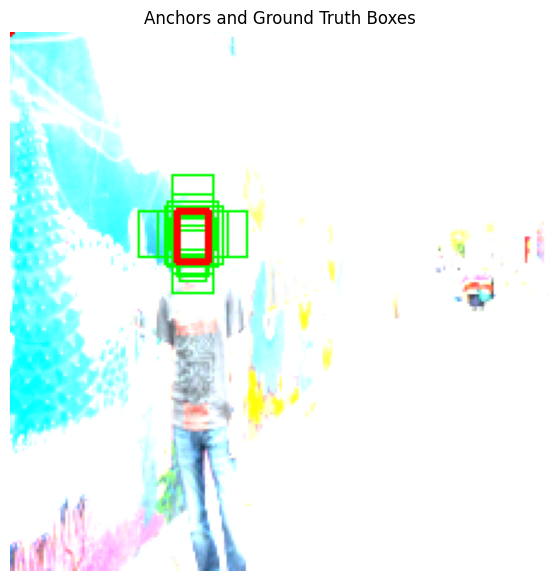

In [11]:
projected_boxes= project_bboxes(sample_label.unsqueeze(0), config.ANCHOR_STRIDE, mode= 'p2a')
projected_boxes= filter_valid_bboxes(projected_boxes.squeeze(0))
matched_boxes, labels, gt_assign= match_anchors_to_gt(all_anchors,
                                            sample_label
                                            ) 
pos_mask= labels == 1
neg_mask= labels == 0
mask= matched_boxes[pos_mask]
all_anchors[mask]
visualize_anchors_and_gt(sample_image, all_anchors[mask], sample_label)